[Starter code used](https://www.kaggle.com/rsmits/keras-efficientnet-b3-training-inference)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings

import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model, Input, load_model
from keras.layers import Input, Dense, Lambda, GlobalAveragePooling2D, Reshape, Permute, multiply, AveragePooling2D, MaxPooling2D, BatchNormalization, Conv2D, Dropout, Activation, concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape

import cv2 
from math import ceil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Iterative-Stratification
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# If using TPU:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Using TensorFlow backend.


In [2]:
# Constants
SEED = 36#21#77#42
np.random.seed(SEED)
tf.random.set_seed(SEED)

HEIGHT = 137
WIDTH = 236
HEIGHT_NEW = 128
WIDTH_NEW = 128
CHANNELS = 3

BATCH_SIZE = 128 
TRAIN_DIR = '.'
TEST_SIZE = 1./8
EPOCHS = 9

RUN_NAME = 'Train3_'
PLOT_NAME1 = RUN_NAME+'LossAndAccuracy.png'
PLOT_NAME2 = RUN_NAME+'Recall.png'

is_keras_tensor = K.is_keras_tensor

In [3]:
def plot_summaries(history, plot_name1, plot_name2):
    # Plot loss and Accuracy 
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    df = pd.DataFrame(history)

    ax[0].plot(df[['root_loss','vowel_loss','consonant_loss', 'val_root_loss','val_vowel_loss','val_consonant_loss']])
    ax[0].set_ylim(0, 2)
    ax[0].set_title('Loss')
    ax[0].legend(['train_root_loss','train_vowel_loss','train_conso_loss', 'val_root_loss','val_vowel_loss','val_conso_loss'],
                loc='upper right')
    ax[0].grid()
    ax[1].plot(df[['root_accuracy','vowel_accuracy','consonant_accuracy', 'val_root_accuracy','val_vowel_accuracy','val_consonant_accuracy']])
    ax[1].set_ylim(0.5, 1)
    ax[1].set_title('Accuracy')
    ax[1].legend(['train_root_acc','train_vowel_acc','train_conso_acc', 'val_root_acc','val_vowel_acc','val_conso_acc'],
                loc='lower right')
    ax[1].grid()
    fig.savefig(plot_name1)

    # Plot Recall 
    fig, ax = plt.subplots(1, 1, figsize = (16, 16))
    df['total_recall'] = (2 * df['root_recall'] + df['vowel_recall_1'] + df['consonant_recall_2']) / 4
    df['val_total_recall'] = (2 * df['val_root_recall'] + df['val_vowel_recall_1'] + df['val_consonant_recall_2']) / 4
    ax.plot(df[['total_recall', 'root_recall','vowel_recall_1','consonant_recall_2', 'val_total_recall', 'val_root_recall','val_vowel_recall_1','val_consonant_recall_2']])
    ax.set_ylim(0.5, 1)
    ax.set_title('Recall')
    ax.legend(['total_recall', 'train_root_recall', 'train_vowel_recall', 'train_conso_recall', 'val_total_recall', 'val_root_recall','val_vowel_recall','val_conso_recall'],
                loc='lower right')
    ax.grid()
    fig.savefig(plot_name2)

# **Image Preprocessing**

[ROI resize](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)

In [4]:
def resize_roi(image, size):
    resized = {}
    resize_size=size
    
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = image[ymin:ymax,xmin:xmax]
    resized_roi = cv2.resize(roi, (resize_size, resize_size), interpolation=cv2.INTER_AREA)

    return resized_roi

# Image Prep
def resize_image(img, WIDTH_NEW, HEIGHT_NEW):
    # Invert
    img = 255 - img

    # Normalize
    img = (img * (255.0 / img.max())).astype(np.uint8)

    # Reshape
    img = img.reshape(HEIGHT, WIDTH)
    img = resize_roi(img, HEIGHT_NEW)

    return img

def resize_and_save_image(train_dir, img, WIDTH_NEW, HEIGHT_NEW, image_id):
    # Resize Image
    image_resized = resize_image(img, WIDTH_NEW, HEIGHT_NEW)
    
    # Save Image
    cv2.imwrite(train_dir + str(image_id) + '.png', image_resized)

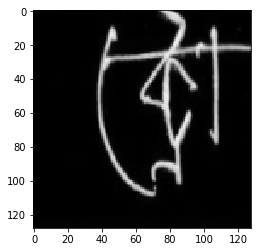

In [5]:
# Feather dir
featherdir = '/kaggle/input/bengaliaicv19feather'

# Loop through train Feather files (X)
first = True
for i in tqdm(range(0, 4)):

    df = pd.read_feather(featherdir+'/train_image_data_'+str(i)+'.feather')
    
    # Get Image Id values
    image_ids = df['image_id'].values 
    # Drop Image_id column
    df = df.drop(['image_id'], axis = 1)

    # Loop over rows in Dataframe and generate images 
    for image_id, index in zip(image_ids, range(df.shape[0])):
        resize_and_save_image(TRAIN_DIR,df.loc[df.index[index]].values, WIDTH_NEW, HEIGHT_NEW, image_id)
        if first:
            img = cv2.imread(TRAIN_DIR+str(image_id)+'.png')
            plt.imshow(img)
            plt.show()
            first = False

    # Cleanup
    del df
    gc.collect()

# **Model Definition**

In [6]:
def squeeze_excite_block(input_tensor, ratio=16):
    """ Create a channel-wise squeeze-excite block
    Args:
        input_tensor: input Keras tensor
        ratio: number of output filters
    Returns: a Keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    """
    init = input_tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = _tensor_shape(init)[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [7]:
# From https://github.com/keras-team/keras-applications/blob/e52c477/keras_applications/imagenet_utils.py#L235-L331
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's tensor shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with {input_shape}'
                    ' input channels.'.format(input_shape=input_shape[0]))
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with {n_input_channels}'
                    ' input channels.'.format(n_input_channels=input_shape[-1]))
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be {default_shape}.'.format(default_shape=default_shape))
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape={input_shape}`'.format(input_shape=input_shape))
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                    (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least {min_size}x{min_size};'
                                     ' got `input_shape={input_shape}`'.format(min_size=min_size,
                                                                               input_shape=input_shape))
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape={input_shape}`'.format(input_shape=input_shape))
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                    (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least {min_size}x{min_size};'
                                     ' got `input_shape={input_shape}`'.format(min_size=min_size,
                                                                               input_shape=input_shape))
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape={input_shape}`'.format(input_shape=input_shape))
    return input_shape


def _tensor_shape(tensor):
    return getattr(tensor, '_keras_shape')

In [8]:
"""DenseNet models for Keras.
# Reference
- [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf)
- [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/pdf/1611.09326.pdf)
"""
def SEDenseNet(input_shape=None,
               depth=40,
               nb_dense_block=3,
               growth_rate=12,
               nb_filter=-1,
               nb_layers_per_block=-1,
               bottleneck=False,
               reduction=0.0,
               dropout_rate=0.0,
               weight_decay=1e-4,
               subsample_initial_block=False,
               include_top=True,
               weights=None,
               input_tensor=None,
               classes=10,
               activation='softmax'):
    """Instantiate the SE DenseNet architecture
        # Arguments
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `channels_last` dim ordering)
                or `(3, 32, 32)` (with `channels_first` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            depth: number or layers in the DenseNet
            nb_dense_block: number of dense blocks to add to end (generally = 3)
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters. -1 indicates initial
                number of filters is 2 * growth_rate
            nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the network depth.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
            bottleneck: flag to add bottleneck blocks in between dense blocks
            reduction: reduction factor of transition blocks.
                Note : reduction value is inverted to compute compression.
            dropout_rate: dropout rate
            weight_decay: weight decay rate
            subsample_initial_block: Set to True to subsample the initial convolution and
                add a MaxPool2D before the dense blocks are added.
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                'imagenet' (pre-training on ImageNet)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
            activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'.
                Note that if sigmoid is used, classes must be 1.
        # Returns
            A Keras model instance.
        """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as ImageNet with `include_top`'
                         ' as true, `classes` should be 1000')

    if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck, reduction,
                           dropout_rate, weight_decay, subsample_initial_block, activation)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='se-densenet')

    return model

def SEDenseNetImageNet169(input_shape=None,
                          bottleneck=True,
                          reduction=0.5,
                          dropout_rate=0.0,
                          weight_decay=1e-4,
                          include_top=True,
                          weights=None,
                          input_tensor=None,
                          classes=1000,
                          activation='softmax'):
    return SEDenseNet(input_shape, depth=169, nb_dense_block=4, growth_rate=32, nb_filter=64,
                      nb_layers_per_block=[6, 12, 32, 32], bottleneck=bottleneck, reduction=reduction,
                      dropout_rate=dropout_rate, weight_decay=weight_decay, subsample_initial_block=True,
                      include_top=include_top, weights=weights, input_tensor=input_tensor,
                      classes=classes, activation=activation)

def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None, weight_decay=1e-4):
    """ Apply BatchNorm, Relu, 3x3 Conv2D, optional bottleneck block and dropout
    Args:
        ip: Input keras tensor
        nb_filter: number of filters
        bottleneck: add bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor with batch_norm, relu and convolution2d added (optional bottleneck)
    """
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)

    if bottleneck:
        inter_channel = nb_filter * 4  # Obtained from https://github.com/liuzhuang13/DenseNet/blob/master/densenet.lua

        x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)

    x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False, dropout_rate=None, weight_decay=1e-4,
                  grow_nb_filters=True, return_concat_list=False):
    """ Build a dense_block where the output of each conv_block is fed to subsequent ones
    Args:
        x: keras tensor
        nb_layers: the number of layers of conv_block to append to the model.
        nb_filter: number of filters
        growth_rate: growth rate
        bottleneck: bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        grow_nb_filters: flag to decide to allow number of filters to grow
        return_concat_list: return the list of feature maps along with the actual output
    Returns: keras tensor with nb_layers of conv_block appended
    """
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x_list = [x]

    for i in range(nb_layers):
        cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay)
        x_list.append(cb)

        x = concatenate([x, cb], axis=concat_axis)

        if grow_nb_filters:
            nb_filter += growth_rate

    # squeeze and excite block
    x = squeeze_excite_block(x)

    if return_concat_list:
        return x, nb_filter, x_list
    else:
        return x, nb_filter


def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4):
    """ Apply BatchNorm, Relu 1x1, Conv2D, optional compression, dropout and Maxpooling2D
    Args:
        ip: keras tensor
        nb_filter: number of filters
        compression: calculated as 1 - reduction. Reduces the number of feature maps
                    in the transition block.
        weight_decay: weight decay factor
    Returns: keras tensor, after applying batch_norm, relu-conv, dropout, maxpool
    """
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    return x


def __create_dense_net(nb_classes, img_input, include_top, depth=40, nb_dense_block=3, growth_rate=12, nb_filter=-1,
                       nb_layers_per_block=-1, bottleneck=False, reduction=0.0, dropout_rate=None, weight_decay=1e-4,
                       subsample_initial_block=False, activation='softmax'):
    """ Build the DenseNet model
    Args:
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        include_top: flag to include the final Dense layer
        depth: number or layers
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters. Default -1 indicates initial number of filters is 2 * growth_rate
        nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the depth of the network.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
        bottleneck: add bottleneck blocks
        reduction: reduction factor of transition blocks. Note : reduction value is inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay rate
        subsample_initial_block: Set to True to subsample the initial convolution and
                add a MaxPool2D before the dense blocks are added.
        activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'.
                Note that if sigmoid is used, classes must be 1.
    Returns: keras tensor with nb_layers of conv_block appended
    """

    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    if reduction != 0.0:
        assert 1.0 >= reduction > 0.0, 'reduction value must lie between 0.0 and 1.0'

    # layers in each dense block
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)  # Convert tuple to list

        assert len(nb_layers) == nb_dense_block, 'If list, nb_layer is used as provided. ' \
                                                 'Note that list size must be (nb_dense_block)'
        final_nb_layer = nb_layers[-1]
        nb_layers = nb_layers[:-1]
    else:
        if nb_layers_per_block == -1:
            assert (depth - 4) % 3 == 0, 'Depth must be 3 N + 4 if nb_layers_per_block == -1'
            count = int((depth - 4) / 3)
            nb_layers = [count for _ in range(nb_dense_block)]
            final_nb_layer = count
        else:
            final_nb_layer = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * nb_dense_block

    # compute initial nb_filter if -1, else accept users initial nb_filter
    if nb_filter <= 0:
        nb_filter = 2 * growth_rate

    # compute compression factor
    compression = 1.0 - reduction

    # Initial convolution
    if subsample_initial_block:
        initial_kernel = (7, 7)
        initial_strides = (2, 2)
    else:
        initial_kernel = (3, 3)
        initial_strides = (1, 1)

    x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal', padding='same',
               strides=initial_strides, use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

    if subsample_initial_block:
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter, growth_rate, bottleneck=bottleneck,
                                     dropout_rate=dropout_rate, weight_decay=weight_decay)
        # add transition_block
        x = __transition_block(x, nb_filter, compression=compression, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    # The last dense_block does not have a transition_block
    x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate, bottleneck=bottleneck,
                                 dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
    #x = GlobalAveragePooling2D()(x)

    if include_top:
        x = Dense(nb_classes, activation=activation)(x)

    return x

In [9]:
# Generalized mean pool - GeM
gm_exp = tf.Variable(3.0, dtype = tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

def create_model(input_shape):
    # Input Layer
    input_tensor = Input(shape = input_shape)
    
    x_model = SEDenseNetImageNet169(input_tensor=input_tensor, include_top=False)
    
    # GeM
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    x = lambda_layer(x_model.output)
    
    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name = 'root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name = 'vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name = 'consonant')(x)

    # model
    model = Model(inputs = x_model.input, outputs = [grapheme_root, vowel_diacritic, consonant_diacritic])

    return model

# **Training**

In [10]:
# Prepare Train Labels (Y)
train_df = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
tgt_cols = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
desc_df = train_df[tgt_cols].astype('str').describe()
types = desc_df.loc['unique',:]
X_train = train_df['image_id'].values
train_df = train_df[tgt_cols].astype('uint8')
for col in tgt_cols:
    train_df[col] = train_df[col].map('{:03}'.format)
Y_train = pd.get_dummies(train_df)

# Cleanup
del train_df
gc.collect()

3

In [11]:
# Modelcheckpoint
def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = False, 
                            save_weights_only = True, # Save entire model for easier loading?
                            mode = 'min', 
                            period = 1)


def _read(path):
    img = cv2.imread(path)    
    return img

In [12]:
# If using TPU:
# with tpu_strategy.scope():
model = create_model((HEIGHT_NEW, WIDTH_NEW, CHANNELS))
# Compile Model
model.compile(optimizer = Adam(lr = 0.00015),
                loss = {'root': 'categorical_crossentropy',
                        'vowel': 'categorical_crossentropy',
                        'consonant': 'categorical_crossentropy'},
                loss_weights = {'root': 0.40,        
                                'vowel': 0.30,
                                'consonant': 0.30},
                metrics = {'root': ['accuracy', tf.keras.metrics.Recall()],
                            'vowel': ['accuracy', tf.keras.metrics.Recall()],
                            'consonant': ['accuracy', tf.keras.metrics.Recall()] })

# Model Summary
print(model.summary())
model.load_weights('/kaggle/input/weights-v1/Train3_model_36.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [13]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, X_set, Y_set, ids, batch_size = 16, img_size = (512, 512, 3), img_dir = TRAIN_DIR, *args, **kwargs):
        self.X = X_set
        self.ids = ids
        self.Y = Y_set
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

        # Split Data
        self.x_indexed = self.X[self.ids]
        self.y_indexed = self.Y.iloc[self.ids]

        # Prep Y per Label   
        self.y_root = self.y_indexed.iloc[:,0:types['grapheme_root']]
        self.y_vowel = self.y_indexed.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
        self.y_consonant = self.y_indexed.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y_root, Y_vowel, Y_consonant = self.__data_generation(indices)
        return X, {'root': Y_root, 'vowel': Y_vowel, 'consonant': Y_consonant}

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y_root = np.empty((self.batch_size, 168), dtype = np.int16)
        Y_vowel = np.empty((self.batch_size, 11), dtype = np.int16)
        Y_consonant = np.empty((self.batch_size, 7), dtype = np.int16)

        for i, index in enumerate(indices):
            ID = self.x_indexed[index]
            image = _read(self.img_dir+ID+".png")
            
            X[i,] = image
            
            Y_root[i,] = self.y_root.iloc[index].values
            Y_vowel[i,] = self.y_vowel.iloc[index].values
            Y_consonant[i,] = self.y_consonant.iloc[index].values    
       
        return X, Y_root, Y_vowel, Y_consonant 

=========== EPOCH 0
Train Length: 175671   First 10 indices: [193087  86349 110054   9001 106698   3697  55086  33872  55992  70731]
Valid Length: 25169    First 10 indices: [ 1  9 20 28 46 48 51 83 87 93]
Train Generator Size: 1373
Validation Generator Size: 197
Epoch 1/1
1373/1373 [==============================] - 1275s 928ms/step - loss: 192.9342 - root_loss: -1.1284 - vowel_loss: 647.5301 - consonant_loss: -3.3240 - root_accuracy: 0.8543 - root_recall: 0.9230 - vowel_accuracy: 0.9408 - vowel_recall_1: 0.9697 - consonant_accuracy: 0.9488 - consonant_recall_2: 0.9744 - val_loss: 3.4620 - val_root_loss: 2.8454 - val_vowel_loss: 0.7930 - val_consonant_loss: 0.5285 - val_root_accuracy: 0.3280 - val_root_recall: 0.7678 - val_vowel_accuracy: 0.7236 - val_vowel_recall_1: 0.9136 - val_consonant_accuracy: 0.8405 - val_consonant_recall_2: 0.9365

Epoch 00001: saving model to Train3_model_0.h5
=========== EPOCH 1
Train Length: 175744   First 10 indices: [  3317  57770  20411 104560  23946 179

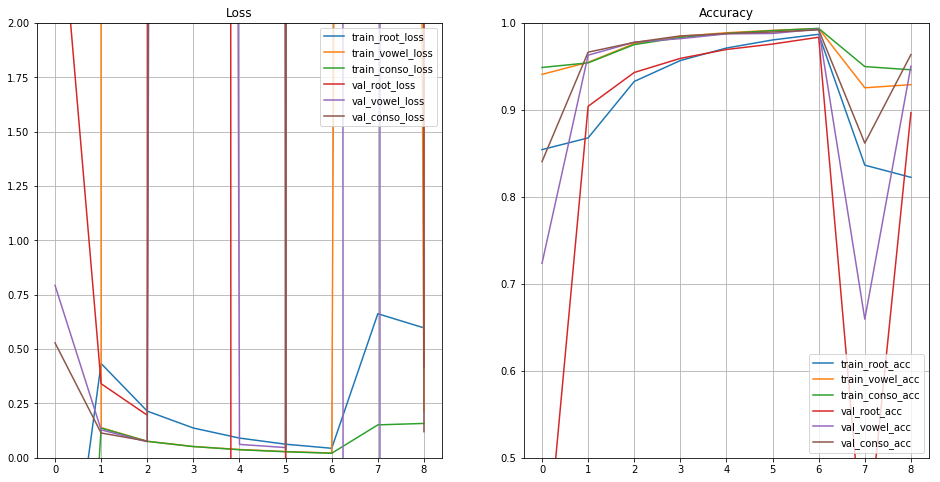

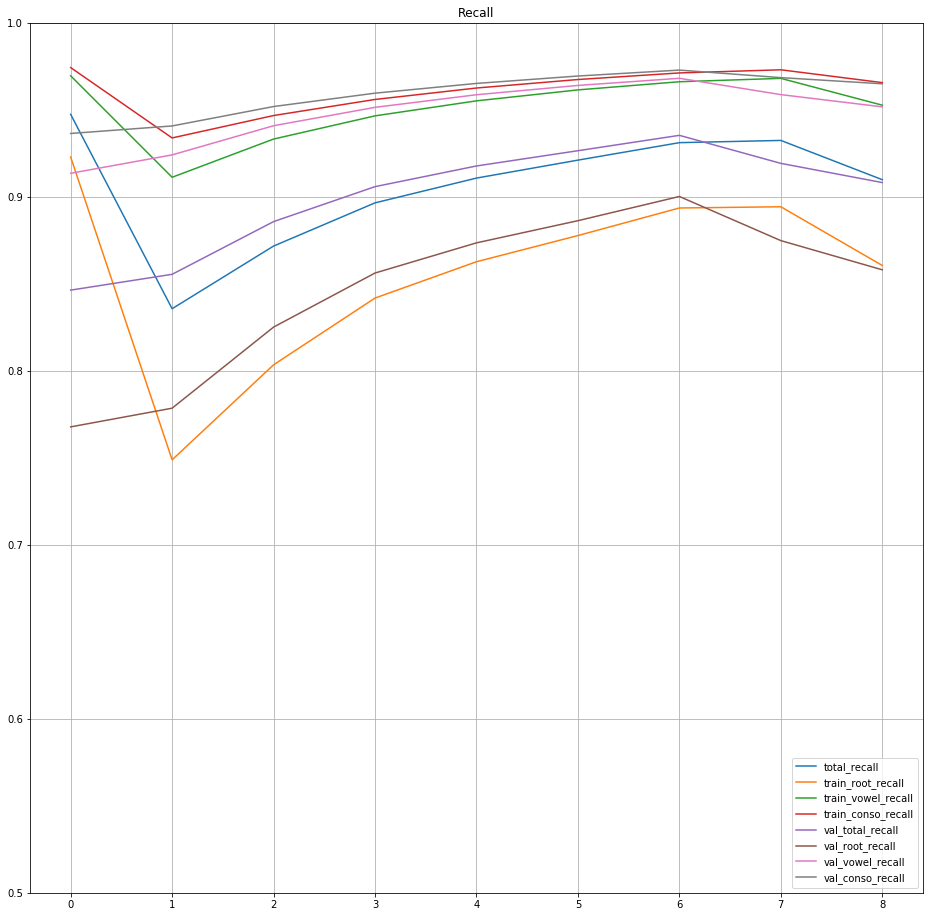

In [14]:
# Multi Label Stratified Split stuff...
msss = MultilabelStratifiedShuffleSplit(n_splits = EPOCHS, test_size = TEST_SIZE, random_state = SEED)

# History Placeholder
history = {}

# If using TPU
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

# Epoch Training Loop
for epoch, msss_splits in zip(range(0, EPOCHS), msss.split(X_train, Y_train)):
    print('=========== EPOCH {}'.format(epoch))

    # Get train and test index, shuffle train indexes.
    train_idx = msss_splits[0]
    valid_idx = msss_splits[1]
    np.random.shuffle(train_idx)
    print('Train Length: {0}   First 10 indices: {1}'.format(len(train_idx), train_idx[:10]))    
    print('Valid Length: {0}    First 10 indices: {1}'.format(len(valid_idx), valid_idx[:10]))

    # Create Data Generators for Train and Valid
    data_generator_train = TrainDataGenerator(X_train, 
                                            Y_train,
                                            train_idx, 
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)
    data_generator_val = TrainDataGenerator(X_train, 
                                            Y_train,
                                            valid_idx,
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)

    TRAIN_STEPS = int(len(data_generator_train))
    VALID_STEPS = int(len(data_generator_val))
    print('Train Generator Size: {0}'.format(len(data_generator_train)))
    print('Validation Generator Size: {0}'.format(len(data_generator_val)))
    
    model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        validation_steps = VALID_STEPS,
                        epochs = 1,
                        callbacks = [ModelCheckpointFull(RUN_NAME + 'model_' + str(epoch) + '.h5')],
                        verbose = 1)

    # Set and Concat Training History
    temp_history = model.history.history
    if epoch == 0:
        history = temp_history
    else:
        for k in temp_history: history[k] = history[k] + temp_history[k]

    # Cleanup
    del data_generator_train, data_generator_val, train_idx, valid_idx
    gc.collect()

# Plot Training Summaries
plot_summaries(history, PLOT_NAME1, PLOT_NAME2)